In this notebook, we try to predict the change of discharge using a neural network model.

## Setup

### Clone data

In [1]:
# !rm -r ml_flood
!git clone https://github.com/esowc/ml_flood.git

Cloning into 'ml_flood'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 1428 (delta 125), reused 138 (delta 77), pack-reused 1235
Receiving objects: 100% (1428/1428), 437.01 MiB | 32.49 MiB/s, done.
Resolving deltas: 100% (879/879), done.
Checking out files: 100% (77/77), done.


### Install dependencies, import modules

In [2]:
!pip install geopandas rasterio netcdf4

     |████████████████████████████████| 921kB 3.5MB/s 
     |████████████████████████████████| 18.0MB 229kB/s 
     |████████████████████████████████| 4.1MB 43.6MB/s 
     |████████████████████████████████| 11.8MB 187kB/s 
     |████████████████████████████████| 10.1MB 40.9MB/s 
     |████████████████████████████████| 317kB 53.7MB/s 


In [0]:
# Working paths
import os
import sys
pjoin = os.path.join
BASE_DIR = pjoin(os.getcwd(), 'ml_flood')
sys.path.insert(1, BASE_DIR)

In [0]:
import numpy as np
import datetime as dt

import joblib
import pandas as pd
import seaborn as sns
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import moment
from sklearn.preprocessing import StandardScaler

matplotlib.rcParams.update({'font.size': 14})

### Fix random seed

In [0]:
SEED = 42
np.random.seed(SEED)

## Data preprocessing

### Load data

In [0]:
# from ml_flood.python.misc.utils_floodmodel import add_time, generate_prediction_array, remove_outlier, multi_forecast_case_study

ds = xr.open_dataset(pjoin(BASE_DIR, 'data/features_xy.nc'))

y_orig = ds['dis']
y = y_orig.copy()
x = ds.drop(['dis', 'dis_diff'])

### Differentiating the predictand

When making a prediction, we want to start at the present state of discharge. The present state of discharge is also determined by man-made decisions, like when dams change the river level, so we cannot assume that we will be able to predict all flow levels in absolute values.

If we just focus on predicting changes in discharge, the model does not have to model the 'mean' but can focus on fitting the changes. It is an easy method and has two side effects:

- a nicer distribution of the predictand so that we can deliberately use Mean-Squared-Error as optimization metric
- the prediction is not conditioned on the present river level

mean: 0.0 , std: 269074.8916842176 , skew: 167850422.6997186


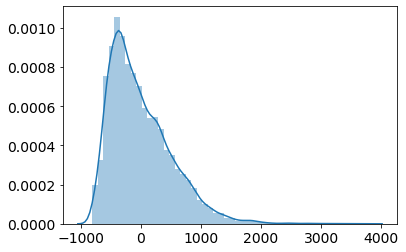

In [7]:
dist = y.values.ravel() - y.mean().values.ravel() 
dist = dist[~np.isnan(dist)]
sns.distplot(dist)
print('mean:', moment(dist, 1), ', std:', moment(dist, 2), ', skew:', moment(dist, 3))

After performing diff:

mean: 0.0 , std: 4181.27897581471 , skew: 1100883.0967652714


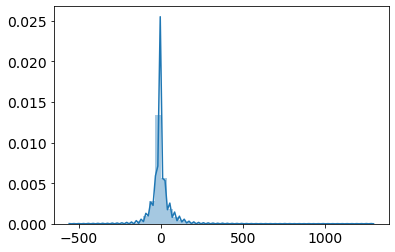

In [8]:
dist = y.diff('time', n=1).values.ravel()
dist = dist[~np.isnan(dist)]
sns.distplot(dist)
print('mean:', moment(dist, 1), ', std:', moment(dist, 2), ', skew:', moment(dist, 3))

In [9]:
y = y.diff('time', 1)
y

<xarray.DataArray 'dis' (time: 13513)>
array([-6.15386963,  4.49841309, 17.52972412, ..., -4.65692139,
       -2.8092041 , 20.63201904])
Coordinates:
  * time     (time) datetime64[ns] 1981-01-02 1981-01-03 ... 2017-12-31

In [0]:
def remove_outlier(x):
    """Removes outliers under, over 1th, 99th percentile of the input pandas series.
    
    Parameters
    ----------
        x : pd.Series
    """
    x99 = x.quantile(0.99)
    x01 = x.quantile(0.01)
    x = x.where(x > x01).dropna()
    x = x.where(x < x99).dropna()
    return x

def reshape_scalar_predictand(X_dis, y):
    """Reshape, merge predictor/predictand in time, drop nans.
    Parameters
    ----------
    X_dis : xr.Dataset
        variables: time shifted predictors (name irrelevant)
        coords: time, latitude, longitude
    y : xr.DataArray
        coords: time
    """
    if isinstance(X_dis, xr.Dataset):
        X_dis = X_dis.to_array(dim='var_dimension')

    # stack -> seen as one dimension for the model
    stack_dims = [a for a in X_dis.dims if a != 'time']  # all except time
    X_dis = X_dis.stack(features=stack_dims)
    Xar = X_dis.dropna('features', how='all')  # drop features that only contain NaN

    if isinstance(y, xr.Dataset):
        if len(y.data_vars) > 1:
            warnings.warn('Supplied `y` with more than one variable.'
                          'Which is the predictand? Supply only one!')
        for v in y:
            y = y[v]  # use the first
            break

    yar = y
    if len(yar.dims) > 1:
        raise NotImplementedError('y.dims: '+str(yar.dims) +
                                  ' Supply only one predictand dimension, e.g. `time`!')

    # to be sure that these dims are not in the output
    for coord in ['latitude', 'longitude']:
        if coord in yar.coords:
            yar = yar.drop(coord)

    # merge times
    yar.coords['features'] = 'predictand'
    Xy = xr.concat([Xar, yar], dim='features')  # maybe merge instead concat?
    Xyt = Xy.dropna('time', how='any')  # drop rows with nan values

    Xda = Xyt[:, :-1]  # last column is predictand
    yda = Xyt[:, -1].drop('features')  # features was only needed in merge
    return Xda, yda

def add_time(vector, time, name=None):
    """Converts input vector to xarray.DataArray with the corresponding input time coordinate.
    
    Parameters
    ----------
        vector : numpy.array
        time   : xr.DataArray
        name   : str
    """
    return xr.DataArray(vector, dims=('time'), coords={'time': time}, name=name)

In [11]:
xda, yda = reshape_scalar_predictand(x, y)
xda.features

<xarray.DataArray 'features' (features: 16)>
array([('cp',), ('lsp',), ('swvl1',), ('ro',), ('sd',), ('sd_diff',),
       ('lsp-4-11',), ('lsp-12-25',), ('lsp-26-55',), ('lsp-56-180',),
       ('lsp-1',), ('lsp-2',), ('lsp-3',), ('cp-1',), ('cp-2',), ('cp-3',)],
      dtype=object)
Coordinates:
  * features  (features) object ('cp',) ('lsp',) ... ('cp-2',) ('cp-3',)

### Split data
Next, we split the dataset into three parts for 
- training (the longest period for estimating the free parameters within the model), 
- validation (for tuning hyperparameters) and 
- testing (for the model comparison).

In [0]:
period_train = dict(time=slice(None, '2005'))
period_valid = dict(time=slice('2006', '2011'))
period_test = dict(time=slice('2012', '2016'))


x_train, y_train = xda.loc[period_train], yda.loc[period_train]
x_valid, y_valid = xda.loc[period_valid], yda.loc[period_valid]
x_test, y_test = xda.loc[period_test], yda.loc[period_test]

In [0]:
def rename_cols(col):
    if 't' in col:
        return col.replace('t', 'Temperature')
    elif 'q' in col:
        return col.replace('q', 'Specific humidity')
    elif 'z' in col:
        return col.replace('z', 'Geopotential')
    elif 'lsp' in col:
        return col.replace('lsp', 'Large-scale precipitation')
    elif 'cp' in col:
        return col.replace('cp', 'Convective precipitation')
    elif 'swvl1' in col:
        return col.replace('swvl1', 'Volumetric soil water layer 2')
    elif 'swvl2' in col:
        return col.replace('swvl2', 'Volumetric soil water layer 2')
    elif 'ro' in col:
        return col.replace('ro', 'Runoff')
    elif 'tcwv' in col:
        return col.replace('tcwv', 'Total column water vapour')
    else:
        return col

train_dataset = x_train.to_pandas().copy()
train_labels = y_train.to_pandas().copy()
valid_dataset = x_valid.to_pandas().copy()
valid_labels = y_valid.to_pandas().copy()
test_dataset = x_test.to_pandas().copy()
test_labels = y_test.to_pandas().copy()
# train_dataset.rename(columns=rename_cols, inplace=True)
# test_dataset.rename(columns=rename_cols, inplace=True)

In [14]:
train_dataset

features,"(cp,)","(lsp,)","(swvl1,)","(ro,)","(sd,)","(sd_diff,)","(lsp-4-11,)","(lsp-12-25,)","(lsp-26-55,)","(lsp-56-180,)","(lsp-1,)","(lsp-2,)","(lsp-3,)","(cp-1,)","(cp-2,)","(cp-3,)"
time,,,,,,,,,,,,,,,,
1981-06-30,0.000148,0.000126,0.319188,0.000037,0.000009,0.000009,0.002152,0.001650,0.001668,0.002075,0.001423,0.000057,0.000041,0.000500,0.000098,0.000289
1981-07-01,0.000048,0.000012,0.311413,0.000037,0.000007,-0.000002,0.001520,0.001986,0.001632,0.002063,0.000126,0.001423,0.000057,0.000148,0.000500,0.000098
1981-07-02,0.000162,0.000003,0.304419,0.000037,0.000001,-0.000006,0.001484,0.001998,0.001633,0.001975,0.000012,0.000126,0.001423,0.000048,0.000148,0.000500
1981-07-03,0.005388,0.008273,0.319030,0.000080,0.000009,0.000008,0.001133,0.002274,0.001642,0.001870,0.000003,0.000012,0.000126,0.000162,0.000048,0.000148
1981-07-04,0.001387,0.001714,0.364614,0.000048,0.000089,0.000080,0.000561,0.002477,0.001704,0.001820,0.008273,0.000003,0.000012,0.005388,0.000162,0.000048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-12-27,0.000213,0.001202,0.358593,0.000024,0.044086,0.002802,0.005114,0.001283,0.001494,0.002017,0.001288,0.001592,0.001017,0.000720,0.000229,0.000009
2005-12-28,0.000241,0.003703,0.355694,0.000024,0.048186,0.004101,0.003081,0.002513,0.001493,0.002012,0.001202,0.001288,0.001592,0.000213,0.000720,0.000229
2005-12-29,0.000047,0.001544,0.353459,0.000024,0.052352,0.004166,0.002789,0.002364,0.001629,0.001951,0.003703,0.001202,0.001288,0.000241,0.000213,0.000720


In [15]:
test_dataset

features,"(cp,)","(lsp,)","(swvl1,)","(ro,)","(sd,)","(sd_diff,)","(lsp-4-11,)","(lsp-12-25,)","(lsp-26-55,)","(lsp-56-180,)","(lsp-1,)","(lsp-2,)","(lsp-3,)","(cp-1,)","(cp-2,)","(cp-3,)"
time,,,,,,,,,,,,,,,,
2012-01-01,0.000365,4.553528e-03,0.396237,0.000042,0.033431,0.002039,0.003186,0.003409,0.000693,0.001961,9.135315e-03,0.006857,0.001659,0.002695,0.004268,0.000375
2012-01-02,0.000739,4.306990e-03,0.391031,0.000036,0.032015,-0.001416,0.002692,0.003213,0.000966,0.001960,4.553528e-03,0.009135,0.006857,0.000365,0.002695,0.004268
2012-01-03,0.000389,7.532169e-04,0.389037,0.000028,0.032983,0.000968,0.002123,0.003981,0.000985,0.001961,4.306990e-03,0.004554,0.009135,0.000739,0.000365,0.002695
2012-01-04,0.001990,6.289419e-03,0.396443,0.000045,0.031996,-0.000988,0.002882,0.003829,0.001158,0.001955,7.532169e-04,0.004307,0.004554,0.000389,0.000739,0.000365
2012-01-05,0.004773,1.064268e-02,0.397110,0.000055,0.034651,0.002655,0.002943,0.003643,0.001377,0.001934,6.289419e-03,0.000753,0.004307,0.001990,0.000389,0.000739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,0.000190,1.229269e-03,0.373959,0.000033,0.007411,0.000509,0.000281,0.000531,0.001878,0.001834,2.039012e-03,0.003484,0.001386,0.000560,0.000046,0.000077
2016-12-28,0.000021,2.117433e-03,0.368764,0.000033,0.008520,0.001109,0.000453,0.000379,0.001841,0.001844,1.229269e-03,0.002039,0.003484,0.000190,0.000560,0.000046
2016-12-29,0.000001,3.220272e-04,0.364660,0.000032,0.008435,-0.000085,0.000887,0.000375,0.001833,0.001846,2.117433e-03,0.001229,0.002039,0.000021,0.000190,0.000560


In [16]:
train_labels

time
1981-06-30   -63.794678
1981-07-01   -52.247681
1981-07-02   -42.400757
1981-07-03   -42.627075
1981-07-04   -32.811157
                ...    
2005-12-27    -3.450104
2005-12-28    -3.834015
2005-12-29    -3.926361
2005-12-30    -3.976288
2005-12-31    -3.813751
Length: 8922, dtype: float64

In [17]:
test_labels

time
2012-01-01    -2.391785
2012-01-02     4.458740
2012-01-03     7.948792
2012-01-04    16.116333
2012-01-05    27.174744
                ...    
2016-12-27    -0.813599
2016-12-28     0.660950
2016-12-29     2.714905
2016-12-30     3.581421
2016-12-31     1.752075
Length: 1827, dtype: float64

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

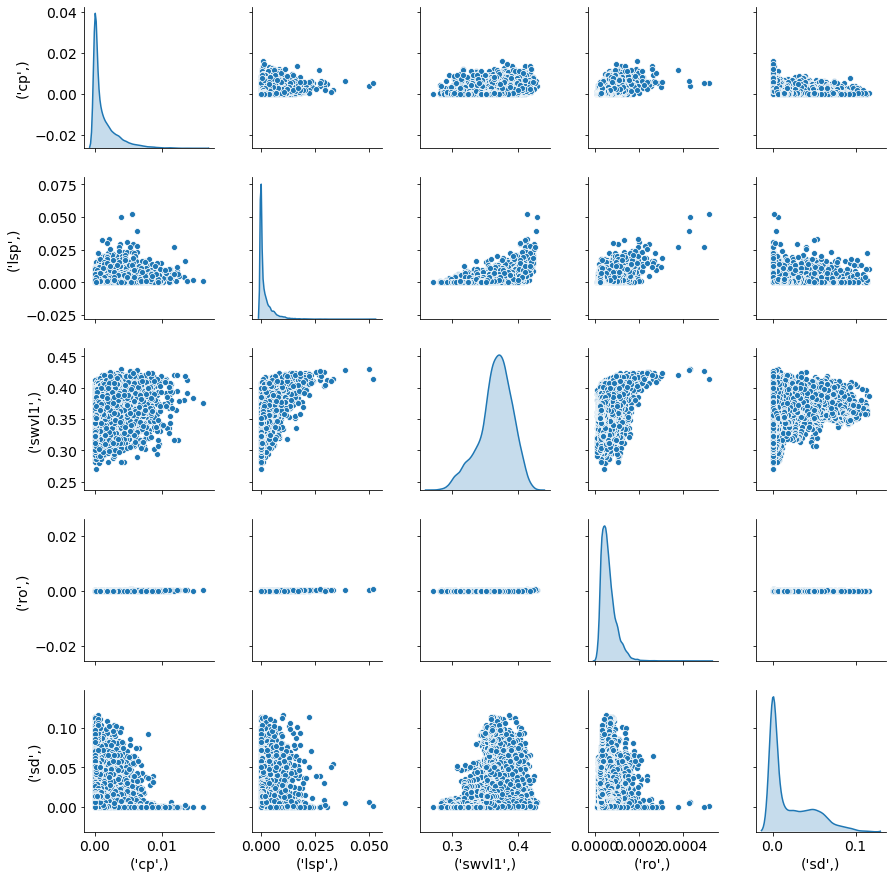

In [18]:
k = list(train_dataset.keys()[:5])
# sns.set(font_scale=0.2)
sns.pairplot(train_dataset[k], diag_kind='kde')

Also look at the overall statistics:

In [19]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
features,,,,,,,,
"(cp,)",8922.0,0.001395,0.001954,-2.081668e-17,0.000040,0.000542,0.002024,0.016178
"(lsp,)",8922.0,0.002016,0.003375,-2.081668e-17,0.000040,0.000556,0.002612,0.052000
"(swvl1,)",8922.0,0.366510,0.025075,2.704897e-01,0.352946,0.369017,0.383773,0.429065
"(ro,)",8922.0,0.000063,0.000034,9.882295e-06,0.000039,0.000056,0.000079,0.000518
"(sd,)",8922.0,0.020623,0.025890,0.000000e+00,0.000091,0.006062,0.038809,0.116514
"(sd_diff,)",8922.0,0.000007,0.001879,-1.739000e-02,-0.000525,-0.000010,0.000143,0.024312
"(lsp-4-11,)",8922.0,0.002016,0.001677,3.225837e-07,0.000757,0.001660,0.002806,0.014314
"(lsp-12-25,)",8922.0,0.002015,0.001318,1.122699e-05,0.001054,0.001796,0.002711,0.009202
"(lsp-26-55,)",8922.0,0.002014,0.000915,1.040338e-04,0.001361,0.001887,0.002560,0.005366


## The model

### Import TensorFlow

Running `%tensorflow_version 2.x` before loading data causes problems.

In [20]:
%tensorflow_version 2.x
import tensorflow as tf
assert tf.version.VERSION.startswith('2.')

TensorFlow 2.x selected.


In [21]:
!pip install -q git+https://github.com/tensorflow/docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

tf.random.set_seed(SEED)

### Build and train the model

A `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`.

Train the model and record the training and validation accuracy in the `history` object.

In [0]:
num_layers = 6     #@param {type:"integer"}
layer_sizes = '20'   #@param {type:"string"}
activation = 'tanh'  #@param {type:"string"}
dropout_rate = 0.2   #@param {type:"number"}
epochs = 300    #@param {type:"integer"}
batch_size = 90  #@param {type:"integer"}

# Config for model_b:
# num_layers = 6
# layer_size = '20'
# batch_size = 

layer_sizes = list(map(int, layer_sizes.split(',')))
if len(layer_sizes) == num_layers:
    assert layer_sizes[-1] == 1
elif len(layer_sizes) == 1:
    layer_sizes = layer_sizes * (num_layers - 1) + [1]
else:
    assert len(layer_sizes) == num_layers - 1
    layer_sizes.append(1)

class Config:
    pass

config = Config()
config.num_layers = num_layers
config.layer_sizes = layer_sizes
config.dropout_rate = dropout_rate
config.activation = activation
config.epochs = epochs
config.batch_size = batch_size
config.loss = 'mse'

In [0]:
class Model(object):
    def __init__(self, model, config):
        self.output_shape = (-1, 1)
        self.config = config
        self.xscaler = StandardScaler()
        self.yscaler = StandardScaler()
        self.opt = tf.keras.optimizers.Adam(
                    learning_rate=1e-3,
                    beta_1=0.9,
                    beta_2=0.999,
                    epsilon=1e-2,
                    amsgrad=True)
        model.compile(
            loss=self.config.loss,
            optimizer=self.opt,
            metrics=['mae', 'mse'])
        self.model = model

        self.callbacks = [tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=1e-2,
            patience=100,
            verbose=1,
            mode='auto',
            baseline=None,
            restore_best_weights=True),]
    
    def score_func(self, X, y):
        """Calculate the RMS error
        
        Parameters
        ----------
        xr.DataArrays
        """
        ypred = self.predict(X)
        err_pred = ypred - y
        
        # NaNs do not contribute to error
        err_pred = err_pred.where(~np.isnan(err_pred), 0.)  
        return float(np.sqrt(xr.dot(err_pred, err_pred)))
        
    def predict(self, Xda, name=None):
        """Input and Output: xr.DataArray
        
        Parameters
        ----------
        Xda : xr.DataArray
            with coordinates (time,)
        """
        X = self.xscaler.transform(Xda.values)
        y = self.model.predict(X).squeeze()
        y = self.yscaler.inverse_transform(y)
        
        y = add_time(y, Xda.time, name=name)
        return y

    def fit(self, X_train, y_train, X_valid, y_valid, **kwargs):
        """
        Input: xr.DataArray
        Output: None
        """
        X_train = self.xscaler.fit_transform(X_train.values)
        y_train = self.yscaler.fit_transform(
                        y_train.values.reshape(self.output_shape))
        
        X_valid = self.xscaler.transform(X_valid.values)
        y_valid = self.yscaler.transform(
            y_valid.values.reshape(self.output_shape))
        
        return self.model.fit(X_train, y_train,
                              validation_data=(X_valid, y_valid), 
                              epochs=self.config.epochs,
                              batch_size=self.config.batch_size,
                              callbacks=self.callbacks,
                              verbose=1, **kwargs)
    
    def evaluate(self, x, y, **kwargs):
        x = self.xscaler.transform(x.values)
        y = self.yscaler.transform(y.values.reshape(self.output_shape))
        return self.model.evaluate(x=x, y=y, **kwargs)

        

In [0]:
def build_model_a(num_layers, 
                  layer_size, 
                  activation, 
                  dropout_rate,
                  input_shape):
    assert isinstance(layer_sizes, list)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=input_shape))

    for i in range(num_layers):
        if i == num_layers:
            activation = None
        model.add(tf.keras.layers.Dense(units=layer_sizes[i], activation=None))
        
        if i != num_layers - 1:
            model.add(tf.keras.layers.BatchNormalization())
            model.add(tf.keras.layers.Activation(activation=activation))
        
        if num_layers > 1 and i not in (0, num_layers - 1):
            model.add(tf.keras.layers.Dropout(rate=dropout_rate, seed=None))
    return model

In [0]:
def build_model_b(num_layers, 
                  layer_sizes, 
                  activation, 
                  dropout_rate,
                  input_shape):
    assert isinstance(layer_sizes, list)
    layer_size = layer_sizes[0]
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=input_shape))
    
    if dropout_rate > 0:
        model.add(tf.keras.layers.Dense(
            units=layer_size, activation=activation))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(rate=dropout_rate, seed=None))
    
    num_layers -= 1
    for i in range(num_layers):
        if i == num_layers - 1:
            layer_size = 1
            activation = None
        model.add(tf.keras.layers.Dense(
            units=layer_size, activation=activation))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(rate=dropout_rate, seed=None))
    return model

In [26]:
core = build_model_b(
    num_layers=config.num_layers, 
    layer_sizes=config.layer_sizes, 
    activation=config.activation,
    dropout_rate=config.dropout_rate,
    input_shape=[len(train_dataset.keys())])

model = Model(model=core, config=config)

model.model.summary()
# print('Example prediction: {}'.format(model.predict(normed_train_data[:10])))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                340       
_________________________________________________________________
batch_normalization (BatchNo (None, 20)                80        
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
batch_normalization_1 (Batch (None, 20)                80        
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                4

In [27]:
history = model.fit(x_train, y_train, x_valid, y_valid)

Train on 8922 samples, validate on 2191 samples
Epoch 1/300
8922/8922 [==============================] - 3s 288us/sample - loss: 2.0923 - mae: 1.0290 - mse: 2.0923 - val_loss: 0.8179 - val_mae: 0.7317 - val_mse: 0.8179
Epoch 2/300
8922/8922 [==============================] - 0s 42us/sample - loss: 1.4656 - mae: 0.8539 - mse: 1.4656 - val_loss: 1.0918 - val_mae: 0.8982 - val_mse: 1.0918
Epoch 3/300
8922/8922 [==============================] - 0s 43us/sample - loss: 1.2577 - mae: 0.7804 - mse: 1.2577 - val_loss: 0.9872 - val_mae: 0.8507 - val_mse: 0.9872
Epoch 4/300
8922/8922 [==============================] - 0s 44us/sample - loss: 1.1519 - mae: 0.7280 - mse: 1.1519 - val_loss: 0.8253 - val_mae: 0.7641 - val_mse: 0.8253
Epoch 5/300
8922/8922 [==============================] - 0s 42us/sample - loss: 1.0808 - mae: 0.6894 - mse: 1.0808 - val_loss: 0.6913 - val_mae: 0.6821 - val_mse: 0.6913
Epoch 6/300
8922/8922 [==============================] - 0s 43us/sample - loss: 1.0087 - mae: 0.6448 

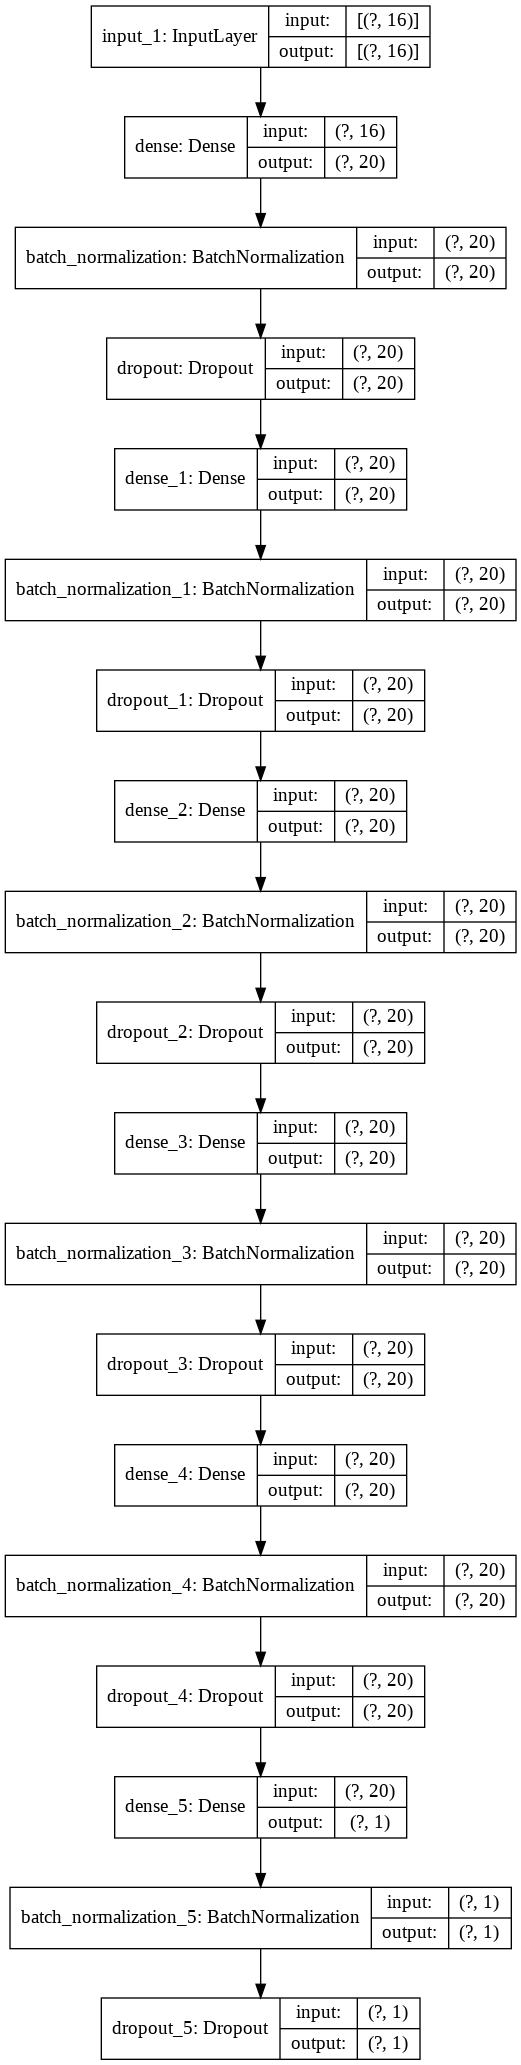

In [28]:
tf.keras.utils.plot_model(model.model, to_file='model.png', show_shapes=True)

In [29]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
295,0.640214,0.452395,0.640214,0.293527,0.308653,0.293527,295
296,0.669033,0.449727,0.669033,0.342972,0.314307,0.342972,296
297,0.652161,0.450791,0.652161,0.334629,0.314176,0.334629,297
298,0.631482,0.452627,0.631482,0.291686,0.308424,0.291686,298
299,0.700626,0.458435,0.700626,0.302559,0.310470,0.302559,299


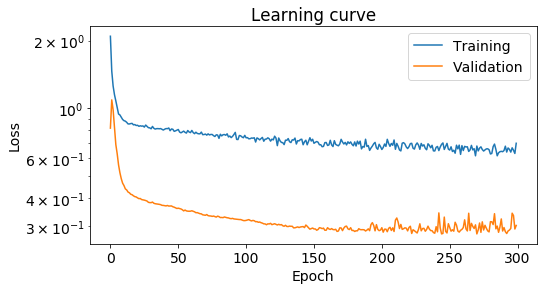

In [30]:
h = history.model.history

# Plot training & validation loss value
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(h.history['loss'], label='loss')
ax.plot(h.history['val_loss'], label='val_loss')
plt.title('Learning curve')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
plt.legend(['Training', 'Validation'])
ax.set_yscale('log')

In [0]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [River discharge in [m3/s]]')

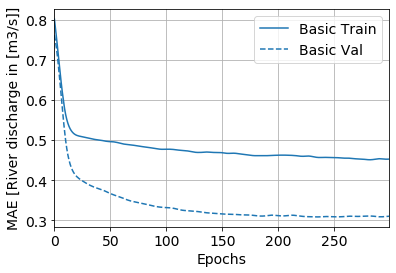

In [32]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylabel('MAE [River discharge in [m3/s]]')

Text(0, 0.5, 'MSE [River discharge in [m3/s]')

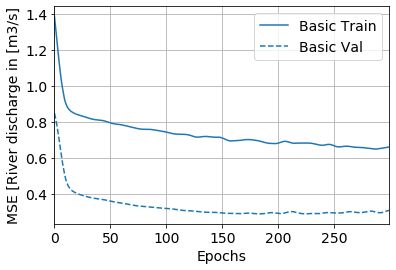

In [33]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylabel('MSE [River discharge in [m3/s]')

### Evaluate on test set

In [34]:
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} [River discharge in [m3/s]]".format(mae))

1827/1827 - 0s - loss: 0.3259 - mae: 0.3249 - mse: 0.3259
Testing set Mean Abs Error:  0.32 [River discharge in [m3/s]]


### Plot predictions

In [0]:
def generate_prediction_array(y_pred, y_truth, forecast_range=14):
    """Convenience function to generate a [number of forecasts, forecast range] shaped xr.DataArray from the one
    dimensional xr.DataArray input prediction and converts the predicted discharge change into absolute values,
    starting from t=t0 with the reanalysis value for each forecast.
    
    Parameters
    ----------
        y_pred          : xr.DataArray
        y_truth         : xr.DataArray
        forecast_range  : int
    """
    # reorganize data into the shape [forecast_range, number_of_forecasts]
    # add +1 to forecast range to include the init state in the length
    num_forecasts = int(np.floor(y_pred.shape[0]/(forecast_range+1)))
    full_forecast_len = num_forecasts*(forecast_range+1)
    new_pred = y_pred[:full_forecast_len].copy()
    time_new = y_pred.time[:full_forecast_len].copy()
    time_new_data = time_new.values.reshape([num_forecasts, (forecast_range+1)])
    pred_multif_data = new_pred.values.reshape([num_forecasts, (forecast_range+1)])
    # set init to reanalysis value
    pred_multif_data[:,0] = y_truth.where(new_pred)[0::(forecast_range+1)].values
    # cumulative sum to accumulate the forecasted change
    pred_multif_data_fin = np.cumsum(pred_multif_data, axis=1)
    
    pred_multif = xr.DataArray(pred_multif_data_fin,
                               coords={'num_of_forecast': range(1, num_forecasts+1),
                                       'forecast_day': range(0, forecast_range+1),
                                       'time': (('num_of_forecast', 'forecast_day'), time_new_data)},
                               dims=['num_of_forecast', 'forecast_day'],
                              name = 'prediction')
    return pred_multif

def plot_multif_prediction(pred_multif, y_truth, forecast_range=14, title=None):
    """Convenience function for plotting multiforecast shaped prediction and truth.
    
    Parameters
    ----------
        pred_multif     : xr.DataArray
        y_truth         : xr.DataArray
        forecast_range  : int
        title           : str
    """
    fig, ax = plt.subplots(figsize=(15,5))
    y_truth.sel({'time': pred_multif.time.values.ravel()}).to_pandas().plot(ax=ax, label='GloFAS Reanalysis')

    pdseries = pd.Series(data=pred_multif.sel(num_of_forecast=1).values,
                         index=pred_multif.sel(num_of_forecast=1).time.values)
    pdseries.plot(ax=ax, label='Model')
    plt.legend()
    for i in pred_multif.num_of_forecast[1:]:
        fcst = pd.Series(data=pred_multif.sel(num_of_forecast=i).values,
                             index=pred_multif.sel(num_of_forecast=i).time.values)
        fcst.plot(ax=ax)

    ax.set_ylabel('river discharge [m$^3$/s]')
        
    y_o = y_truth.loc[{'time': pred_multif.time.values.ravel()}].values
    y_m = pred_multif.values.ravel()

    rmse = np.sqrt(np.nanmean((y_m - y_o)**2))
    nse = 1 - np.sum((y_m - y_o)**2)/(np.sum((y_o - np.nanmean(y_o))**2))

    plt.title(f"{title} | RMSE={round(float(rmse), 2)}; NSE={round(float(nse), 2)} |")
    return fig, ax

In [0]:
y_pred_train = model.predict(x_train)
y_pred_train = generate_prediction_array(y_pred_train, y_orig, forecast_range=14)

y_pred_valid = model.predict(x_valid)
y_pred_valid = generate_prediction_array(y_pred_valid, y_orig, forecast_range=14)

y_pred_test = model.predict(x_test)
y_pred_test = generate_prediction_array(y_pred_test, y_orig, forecast_range=14)

(<Figure size 1080x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2eee1450b8>)

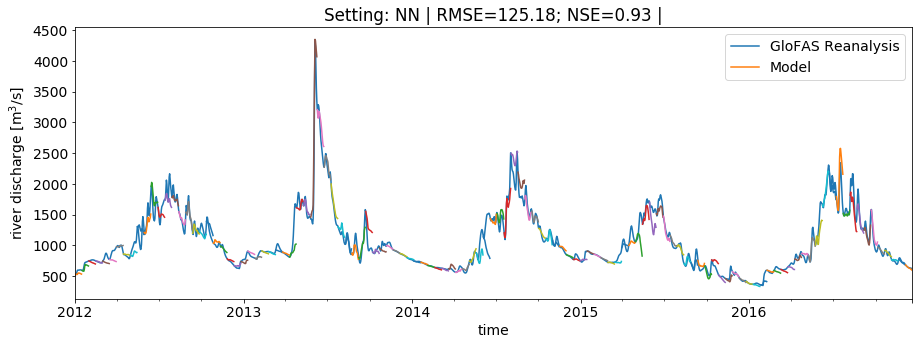

In [37]:
title='Setting: NN'
plot_multif_prediction(y_pred_test, y_orig, forecast_range=14, title=title)

RMSE: Root mean squared error

NSE: Nash–Sutcliffe model efficiency

|   varying param     |   RMSE   |   NSE   | 
| :--------: | :-----: | :-----: | 
| persistence 14-day forecast  | 251.09 | 0.77 |


The NN is much better than the 14-day persistence forecast (which is the absolute minimum threshold a model has to reach).